In [6]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from pandas import read_csv, DataFrame
from os import system
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
#from pip._internal import main as main_pip
#main_pip(['install','sklearn', '--upgrade'])

In [10]:
input_data    = 'labeled_results_20190710.tsv'
input_data = 'results/labeled_results.tsv'
file_to_write = 'relevance_predictions_rf_20190711.csv'

# Read data

In [11]:
df = pd.read_csv(input_data,delimiter='\t').fillna(0.)


C:\Users\cpieterse\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create normalised columns

In [12]:
feature_cols_es = [x for x in df.columns if 'score_title' in x]
feature_cols_domcat = [x for x in df.columns if (('L' in x) and ('_score' in x)) ]+['category_breadcrumb_score']

feature_cols_es_normalised = []
for n_col in feature_cols_es:
    new_col_name = n_col+'_normalised'
    df[new_col_name] = df[n_col] / df['query_tokens'].astype(float)
    feature_cols_es_normalised.append(new_col_name)

# Split labeled and unlabeled data

In [13]:
df_labeled = df[df['relevant']!=0]
df_unlabeled = df[df['relevant']==0]

In [140]:
sample_weights = pd.merge(left=df_labeled[['queryid', 'adid']] 
                       , right=df_labeled[['queryid', 'relevant']].groupby('queryid').count()
                          , how='inner', on='queryid'
                       )
sample_weights['sample_weight'] = 1/sample_weights['relevant']
sample_weights = sample_weights[['queryid', 'adid','sample_weight']]

df_labeled = pd.merge(df_labeled, sample_weights, how='inner', on=['queryid','adid'])
df_unlabeled['sample_weight'] = np.ones(df_unlabeled.shape[0]) 

C:\Users\cpieterse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Train and predict 

In [123]:
def split_test_train(df,model_features_columns,model_target_column):
    X = df[model_features_columns]#.values
    y = df[[model_target_column]]#.values

    df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    return df_x_train, df_x_test, df_y_train, df_y_test

def train(x_train, y_train, model_features_columns,
                     model_type='rf'
          , sample_weight=None
          , **kwargs):

    if model_type=='rf':
        # Create a random forest Classifier
        clf = RandomForestClassifier(n_estimators=50, max_depth=10,
                                 random_state=0, **kwargs)
    elif model_type == 'gbt':
        clf = GradientBoostingClassifier(random_state=0,
                                        n_estimators=200, **kwargs)

    print("TRAINING . . . . . . ")
    # Train the Classifier to take the training features and learn how they relate
    # to the training y (the species)
    clf.fit(x_train[model_features_columns].values, y_train.values.ravel(), sample_weight)

    print("DONE training")
    
    return clf

def predict(x_list,model_features_columns,clf,model_type='rf'):
    
    for i,dataset in enumerate(x_list):# Add predictions to dataframe
        x_list[i]['prediction_'+model_type] = clf.predict(x_list[i][model_features_columns].values)
        

        x_list[i]['probability_class_1_'+model_type] =    \
                    [x[1] for x in clf.predict_proba(x_list[i][model_features_columns].values)] 

    print("DONE predicting") 
    
    return x_list
    
def add_labels_to_test_and_train_data(x_train,x_test,y_train,y_test):
     # Add labels
    x_test['relevant'] = y_test.values
    x_train['relevant'] = y_train.values 
    return x_test,x_train


In [128]:
model_features_columns = feature_cols_es + feature_cols_domcat + feature_cols_es_normalised + ['queryid'] + ['sample_weight']

model_target_column = 'relevant'

# Split in test and train
x_train, x_test, y_train, y_test = split_test_train(df_labeled,model_features_columns,model_target_column)
print(x_train.columns)

# Train and predict two models
clf_rf                 = train(x_train, y_train, model_features_columns, model_type='rf')
clf_rf_minsplit        = train(x_train, y_train, model_features_columns, model_type='rf'
                               , min_samples_split = 2
                               , sample_weight=x_train['sample_weight']
                               , bootstrap=False
                               , class_weight='balanced') # dict(1=3,-1,1))
clf_gbt                = train(x_train, y_train, model_features_columns, model_type='gbt')

[x_train,x_test]  = predict([x_train,x_test],model_features_columns,clf_rf,model_type='rf')
[x_train,x_test] = predict([x_train,x_test],model_features_columns,clf_rf_minsplit,model_type='rf_minsplit')
[x_train,x_test] = predict([x_train,x_test],model_features_columns,clf_gbt,model_type='gbt')


# Add labels to final dataframes
x_test,x_train = add_labels_to_test_and_train_data(x_test,x_train,y_test,y_train)

Index(['score_title.title_shingles', 'score_title.title_stems',
       'score_title.title_tokens', 'score_title_category.stems',
       'score_title_customized.stems', 'score_title_category_customized.stems',
       'L2_score', 'L3_score', 'L4_score', 'L5_score', 'L~_score',
       'category_breadcrumb_score', 'score_title.title_shingles_normalised',
       'score_title.title_stems_normalised',
       'score_title.title_tokens_normalised',
       'score_title_category.stems_normalised',
       'score_title_customized.stems_normalised',
       'score_title_category_customized.stems_normalised', 'queryid',
       'sample_weight'],
      dtype='object')
TRAINING . . . . . . 
DONE training
TRAINING . . . . . . 
DONE training
TRAINING . . . . . . 
DONE training
DONE predicting
DONE predicting
DONE predicting


# Feature importances

In [129]:
def make_features_plot(model_features_columns,rf_fit_once):
    df_features = pd.DataFrame(model_features_columns,columns=['features'])
    df_features['importances'] = rf_fit_once.feature_importances_
    df_features\
            .set_index('features')\
            .sort_values(by='importances',ascending=False)\
            .plot(kind='bar')

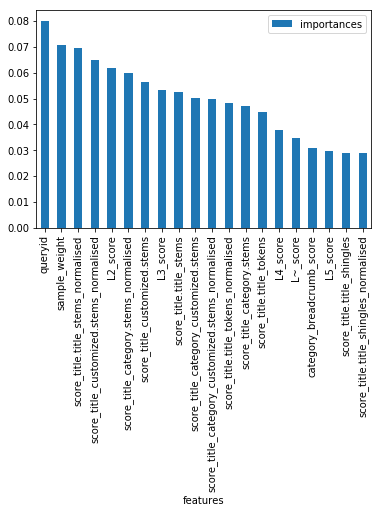

In [130]:
make_features_plot(model_features_columns,clf_rf)

# Evaluation

In [131]:
prediction_columns = [ 'prediction_rf', 
    'prediction_rf_minsplit'
                       #'prediction_RF_cross_validate',
                      # 'prediction_gbt'
                     ]

In [132]:
def calculate_performance(test_pd,train_pd,prediction_columns, model_target_column=''):

    data_sets  = []
    models     = []
    accuracies = []
    precisions = []
    recalls    = []
    f1_scores  = []

    for test_or_train in ['test','train']:
        if test_or_train == 'test':
            data_set = test_pd
        if test_or_train == 'train':
            data_set = train_pd

        for model_prediction_columns in prediction_columns:
            print(model_prediction_columns)

            accuracy = metrics.accuracy_score(data_set[model_target_column],
                                              data_set[prediction_columns])

            precision = metrics.precision_score(data_set[model_target_column],
                                                data_set[prediction_columns])

            recall = metrics.recall_score(data_set[model_target_column],
                                          data_set[prediction_columns])

            f1_score = metrics.f1_score(data_set[model_target_column],
                                        data_set[prediction_columns]) 

            data_sets.append(test_or_train)
            models.append(model_prediction_columns.replace('prediction_',''))
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)


    evaluation_stats = pd.DataFrame([
                                        data_sets,
                                        models,
                                        accuracies,
                                        precisions,
                                        recalls,
                                        f1_scores
    ]
                                   ).transpose()

    evaluation_stats.columns = [
                                        'data_sets',
                                        'models',
                                        'accuracy',
                                        'precision',
                                        'recall',
                                        'f1_score'
    ]

    evaluation_stats.sort_values('accuracy')
    
    return evaluation_stats

In [133]:
evaluation_stats = pd.concat( [calculate_performance(x_test,x_train,
                                         [col],
                                         model_target_column='relevant')
                              for col in prediction_columns])

prediction_rf
prediction_rf
prediction_rf_minsplit
prediction_rf_minsplit


In [134]:
prediction_columns

['prediction_rf', 'prediction_rf_minsplit']

In [135]:
evaluation_stats.head()

,data_sets,models,accuracy,precision,recall,f1_score
0,test,rf,0.816256,0.818812,0.965526,0.886138
1,train,rf,0.783739,0.79498,0.949402,0.865356
0,test,rf_minsplit,0.765294,0.89488,0.773971,0.830046
1,train,rf_minsplit,0.729198,0.856052,0.757408,0.803714


# Predict for unlabelled set

In [141]:
[df_unlabeled] = predict([df_unlabeled],model_features_columns,clf_rf,model_type='rf')
df_unlabeled['prediction_rf'] = df_unlabeled['prediction_rf'].apply(lambda x: 0 if x==-1 else x)

C:\Users\cpieterse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\cpieterse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DONE predicting


C:\Users\cpieterse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [142]:
df_unlabeled['prediction_rf'].value_counts()

1.0    260131
0.0     76342
Name: prediction_rf, dtype: int64

In [155]:
df_unlabeled.to_csv(file_to_write,index=False)

Index(['Unnamed: 0', 'queryid', 'adid', 'score', 'query', 'query_tokens',
       'category', 'title', 'score_title.title_shingles',
       'score_title.title_stems', 'score_title.title_tokens',
       'score_title_category.stems', 'score_title_customized.stems',
       'score_title_category_customized.stems', 'Unnamed: 0.1', 'relevant',
       'category_L1', 'category_L2', 'category_L3', 'category_L4',
       'category_L5', 'category_L-1', 'category_L~',
       'category_breadcrumb_score', 'L2_score', 'L3_score', 'L4_score',
       'L5_score', 'L~_score', 'score_title.title_shingles_normalised',
       'score_title.title_stems_normalised',
       'score_title.title_tokens_normalised',
       'score_title_category.stems_normalised',
       'score_title_customized.stems_normalised',
       'score_title_category_customized.stems_normalised', 'prediction_rf',
       'probability_class_1_rf', 'sample_weight'],
      dtype='object')

In [151]:
def get_metrics_at_threshold(df, column, threshold):
    real_pos = list(np.sign(df['relevant']))
    pred_pos = list(df[column].apply(lambda x: 1 if x>=threshold else -1))
    score = metrics.f1_score(real_pos,pred_pos, pos_label=1)
    return dict(t=threshold
                , score=score
                , recall=metrics.recall_score(real_pos,pred_pos)
                , accuracy=metrics.accuracy_score(real_pos,pred_pos)
                , precision=metrics.precision_score(real_pos,pred_pos))

def best_threshold(df, column, verbose=False):
    min_t = df[column].min()
    max_t = df[column].max()
    best_score = dict(t=min_t, score=-100)
    real_pos = list(np.sign(df['relevant']))
    
    for i in range(100):
        t = min_t + i * (max_t-min_t)/(100-1)
        pred_pos = list(df[column].apply(lambda x: 1 if x>=t else -1))
        score = metrics.f1_score(real_pos,pred_pos, pos_label=1)
        if score > best_score['score']:
            best_score = dict(t=t
                              , score=score
                              , recall=metrics.recall_score(real_pos,pred_pos)
                              , accuracy=metrics.accuracy_score(real_pos,pred_pos)
                              , precision=metrics.precision_score(real_pos,pred_pos))
            if verbose:
                print(best_score)
    return best_score
    

In [156]:
best_t = best_threshold(x_train, column='probability_class_1_rf')

In [157]:
get_metrics_at_threshold(x_test, column='probability_class_1_rf', threshold=best_t['t'])

{'t': 0.5910672940622563,
 'score': 0.8855614973262033,
 'recall': 0.9396599717356858,
 'accuracy': 0.8201566612754891,
 'precision': 0.8373530758662799}

In [158]:
df_unlabeled['relevant'] = df_unlabeled['probability_class_1_rf'].apply(lambda x: 1 if x>=best_t['t'] else 0)
df_unlabeled[['queryid','adid','relevant']].to_csv(file_to_write.replace('.csv','_t.csv'),index=False)

C:\Users\cpieterse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [146]:
best_threshold(x_train, column='probability_class_1_rf_minsplit')

{'t': 0.31120539649890083,
 'score': 0.8655555555555555,
 'recall': 0.944896898284526,
 'accuracy': 0.7851344495180111,
 'precision': 0.798506369893103}

In [154]:
get_metrics_at_threshold(x_test, column='probability_class_1_rf', threshold=0.31120539649890083)

{'t': 0.31120539649890083,
 'score': 0.8741472948339691,
 'recall': 0.9960173011862447,
 'accuracy': 0.787619319443123,
 'precision': 0.7788493737860827}

In [147]:
df_labeled.groupby('queryid').count()
df_labeled.shape

(57314385, 39)